# Recurrent Neural Newtork para a previsão dos dados do INMET

Rede neural RNN com função sigmoide para a previsão da variável target "PRECIPITACAO TOTAL, HORARIO (mm)"

## Imports

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

In [93]:
df = pd.read_csv("Banco de dados/inmet_filtrado_mirante.csv", index_col=0)

## Preparo dos dados

### Normalização (Por desvio padrão)

O código abaixo é aplicado column-wise

In [94]:
scaler = StandardScaler()
df_norm = df
df_norm=pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [95]:
df_norm.head(2)

,"PRECIPITACAO TOTAL, HORARIO(mm)",TEMPERATURA DO PONTO DE ORVALHO(°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(°C),UMIDADE REL. MAX. NA HORA ANT. (AUT)(%),"UMIDADE RELATIVA DO AR, HORARIA(%)","VENTO, RAJADA MAXIMA(m/s)"
Data,,,,,,,
2010-10-10 00:00:00,-0.125997,-0.711166,-0.867267,-0.673136,0.902526,0.995880,0.757265
2010-10-10 01:00:00,-0.125997,-0.738243,-0.839538,-0.620392,0.902526,0.826647,0.373709


### Filtragem e dicotomização do modelo para precipitação

A fórmula utilizada pelo StandardScaler é: $x_{norm} = \dfrac{x_{i} - \overline{x}}{\sigma}$ então o valor mínimo (0) ficará negativo

Fonte: https://www.geeksforgeeks.org/ml-feature-scaling-part-2/

In [96]:
filtrar_ = lambda value: int(value > 0)

In [97]:
features = list(df_norm.columns[df_norm.columns != "PRECIPITACAO TOTAL, HORARIO(mm)"])

In [98]:
conj_x = df_norm[features]
y = df_norm['PRECIPITACAO TOTAL, HORARIO(mm)']
y = y.apply(filtrar_)

Já separa treino do teste!

In [99]:
conj_x_train, conj_x_test, y_train, y_test = train_test_split(conj_x, y, test_size=0.2, random_state=42)

In [124]:
n_features = len(conj_x.columns)
out_steps = 24
in_steps = 48

In [125]:
def create_input_output_sequences(X, y, input_steps=48, output_steps=24):
    x_seq, y_seq = [], []
    max_index = len(X) - input_steps - output_steps
    for i in range(max_index):
        x_seq.append(X.iloc[i:i+input_steps].values)
        y_seq.append(y.iloc[i+input_steps:i+input_steps+output_steps].values)
    return np.array(x_seq), np.array(y_seq)

x_train_seq, y_train_seq = create_input_output_sequences(conj_x_train, y_train, in_steps, out_steps)
x_test_seq, y_test_seq = create_input_output_sequences(conj_x_test, y_test, in_steps, out_steps)

## Treino do RNN

### Criação do modelo

Baseado nas últimas 48h para prever as próximas 24h

In [126]:
model = keras.models.Sequential([
    keras.layers.LSTM(128, activation='tanh', input_shape=(in_steps, n_features), return_sequences=False),
    keras.layers.RepeatVector(out_steps),
    keras.layers.LSTM(64, activation='tanh', return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1, activation='sigmoid'))
])
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 128)            │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 24, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 24, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,593 (463.25 KB)

 Trainable params: 118,593 (463.25 KB)

 Non-trainable params: 0 (0.00 B)

In [127]:
# model = keras.models.Sequential()
# model.add(keras.layers.Input(shape=(in_steps,n_features))) # timestep, features
# model.add(keras.layers.LSTM(32))
# model.add(keras.layers.Dense(64, activation='relu'))
# model.add(keras.layers.Dropout(0.1))
# model.add(keras.layers.Dense(out_steps, activation="sigmoid"))
# model.summary()

### Treino do modelo

In [128]:
y_test_seq

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [129]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history = model.fit(x_train_seq, y_train_seq, epochs=5, batch_size=256, validation_data=(x_test_seq, y_test_seq), callbacks=[early_stopping])

Epoch 1/5


2025-05-25 19:08:37.192700: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 118073088 exceeds 10% of free system memory.


401/401 ━━━━━━━━━━━━━━━━━━━━ 205s 478ms/step - accuracy: 0.9121 - loss: 0.3154 - val_accuracy: 0.9200 - val_loss: 0.2788
Epoch 2/5
401/401 ━━━━━━━━━━━━━━━━━━━━ 185s 460ms/step - accuracy: 0.9211 - loss: 0.2760 - val_accuracy: 0.9200 - val_loss: 0.2793
Epoch 3/5
401/401 ━━━━━━━━━━━━━━━━━━━━ 184s 458ms/step - accuracy: 0.9210 - loss: 0.2765 - val_accuracy: 0.9200 - val_loss: 0.2788
Epoch 4/5
401/401 ━━━━━━━━━━━━━━━━━━━━ 203s 461ms/step - accuracy: 0.9212 - loss: 0.2759 - val_accuracy: 0.9200 - val_loss: 0.2788
Epoch 5/5
401/401 ━━━━━━━━━━━━━━━━━━━━ 185s 461ms/step - accuracy: 0.9212 - loss: 0.2760 - val_accuracy: 0.9200 - val_loss: 0.2788


Treino vs. Acurácia!

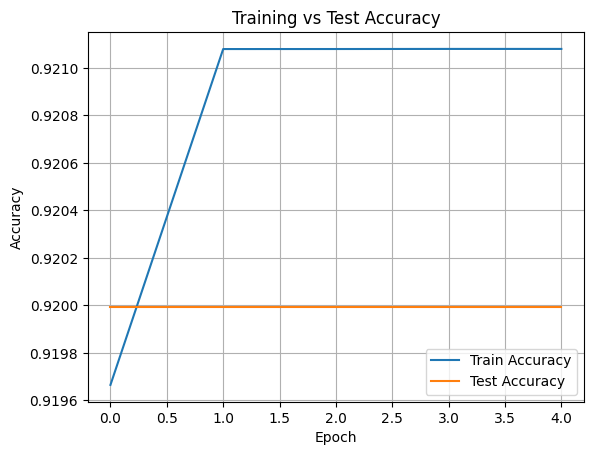

In [130]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Predição

In [131]:
y_pred_prob = model.predict(x_test_seq)

800/800 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step


In [132]:
y_pred = (y_pred_prob > 0.5).astype(int)

In [133]:
for true, pred in zip(y_test_seq[:10], y_pred[:10]):
    print(f"True: {true} - Predicted: {pred}")

True: [0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] - Predicted: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
True: [1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] - Predicted: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
True: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] - Predicted: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
True: [1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] - Predicted: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
True: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] - Predicted: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
True: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Salvando o melhor modelo atual

In [135]:
model.save("2r2n.keras")

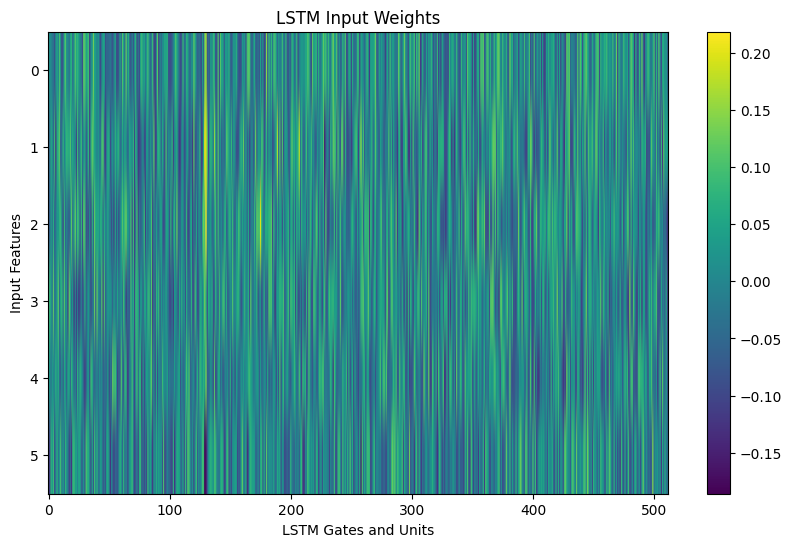

In [ ]:
# Example: Visualize the input weights to the first LSTM layer
layer = model.layers[0]  # assuming it's an LSTM
weights = layer.get_weights()[0]  # input weights (kernel)

# weights shape: (input_dim, 4 * units)
plt.figure(figsize=(10, 6))
plt.imshow(weights, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("LSTM Input Weights")
plt.xlabel("LSTM Gates and Units")
plt.ylabel("Input Features")
plt.show()
